Ok, is it possible at all to distinguish between styles? Let's find out.

In [1]:
% load_ext autoreload
% autoreload 2
% matplotlib inline
% env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import sys; sys.path += ['..', '../src']
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'
read_data = lambda d: open(os.path.join(DATA_PATH, d)).read().splitlines()

train_src = read_data('news.ru.tok.ne.unk_ne.common.bpe')
train_trg = read_data('classics.split.tok.ne.unk_ne.common.bpe')

min_len = 10
max_len = 100

# Removing too short and too long sentences
print('Num lines before:', len(train_src), len(train_trg))
filter_by_length = lambda corpus: [s for s in corpus if min_len <= len(s.split()) <= max_len]
train_src = filter_by_length(train_src)
train_trg = filter_by_length(train_trg)
print('Num lines after :', len(train_src), len(train_trg))

Num lines before: 3523148 3955090
Num lines after : 2798683 2637276


In [3]:
from sklearn.model_selection import train_test_split

vocab = Vocab.from_sequences(train_src + train_trg)

tokenize = lambda corpus: [[vocab.token2id[t] for t in s.split()] for s in corpus]
train_src_idx = tokenize(train_src)
train_trg_idx = tokenize(train_trg)

train_src_idx, val_src_idx = train_test_split(train_src_idx, test_size=1000, random_state=42)
train_trg_idx, val_trg_idx = train_test_split(train_trg_idx, test_size=1000, random_state=42)

In [22]:
from src.models import TransformerClassifier

transformer_kwargs = {
    'd_model': 512,
}

model = TransformerClassifier(len(vocab), 2, max_len+2, **transformer_kwargs)

In [23]:
import numpy as np

def compute_accuracy(logits, targets, threshold=0.5):
    preds = logits > np.log(threshold)
    acc = (preds == targets.byte()).float().sum() / preds.numel()
    
    return acc.data[0]

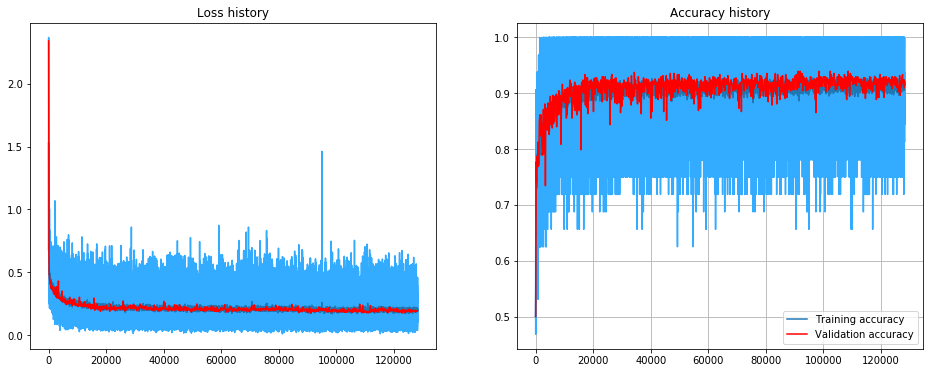

In [24]:
import math
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm; tqdm.monitor_interval = 0

from src.dataloaders import Batcher
from src.vocab import constants
from src.utils.common import variable

use_cuda = torch.cuda.is_available()

optimizer = Adam(model.get_trainable_parameters(), lr=1e-4, betas=(0.9, 0.98))
criterion = nn.BCEWithLogitsLoss()
training_data = Batcher(train_src_idx, train_trg_idx, vocab.token2id,
                        vocab.token2id, batch_size=16, parallel=False)
val_data = Batcher(val_src_idx[:256], val_trg_idx[:256], vocab.token2id,
                   vocab.token2id, batch_size=16, shuffle=False)

if use_cuda: model.cuda()

loss_history = []
acc_history = []
val_loss_history = []
val_iters = []
val_acc_history = []
num_iters_done = 0
max_num_epochs = 50

try:
    for i in range(max_num_epochs):
        for batch in tqdm(training_data, leave=False):
            src, trg = batch
            model.train()
            
            src_targets = variable(torch.zeros(src.size(0)))
            trg_targets = variable(torch.ones(trg.size(0)))
            targets = torch.cat((src_targets, trg_targets))
            
            pred_src = model(src)
            pred_trg = model(trg)
            pred = torch.cat((pred_src, pred_trg))
            
            loss = criterion(pred, targets.contiguous())
            acc = compute_accuracy(pred, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_history.append(loss.data[0])
            acc_history.append(acc)

            if num_iters_done % 50 == 0:
                clear_output(True)
                plt.figure(figsize=[16,6])
                plt.subplot(121)
                plt.title("Loss history")
                plt.plot(loss_history, color='#33ACFF')
                plt.plot(pd.DataFrame(np.array(loss_history)).ewm(span=100).mean(), label='Training loss')
                plt.plot(val_iters, val_loss_history, label='Validation loss', color='red')
                
                plt.subplot(122)
                plt.title('Accuracy history')
                plt.plot(acc_history, color='#33ACFF')
                plt.plot(pd.DataFrame(np.array(acc_history)).ewm(span=100).mean(), label='Training accuracy')
                plt.plot(val_iters, val_acc_history, label='Validation accuracy', color='red')
                
                plt.grid()
                plt.legend()
                plt.show()

            if num_iters_done % 100 == 0:
                val_losses = []
                val_accs = []
                
                for val_batch in val_data:
                    val_src, val_trg = val_batch
                    
                    val_src_targets = variable(torch.zeros(val_src.size(0)))
                    val_trg_targets = variable(torch.ones(val_trg.size(0)))

                    val_targets = torch.cat((val_src_targets, val_trg_targets))
                    
                    val_pred_src = model(val_src)
                    val_pred_trg = model(val_trg)
                    val_pred = torch.cat((val_pred_src, val_pred_trg))

                    val_loss = criterion(val_pred, val_targets.contiguous())
                    
                    val_losses.append(val_loss.data[0])
                    val_acc = compute_accuracy(val_pred, val_targets)
                    val_accs.append(val_acc)

                val_loss_history.append(np.mean(val_losses))
                val_acc_history.append(np.mean(val_accs))
                val_iters.append(num_iters_done)

            num_iters_done += 1
except KeyboardInterrupt:
    pass